# 多类分类(多个logistic回归)

对于此练习，我们将使用逻辑回归来识别手写数字（0到9）。 我们将扩展我们在练习2中写的逻辑回归的实现，并将其应用于一对一的分类。 让我们开始加载数据集。 它是在MATLAB的本机格式，所以要加载它在Python，我们需要使用一个SciPy工具。

In [22]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat

## 1、加载数据集
首先，加载数据集。这里的数据集为MATLAB的格式，所以要使用SciPy.io的loadmat函数。

In [25]:
def load_data(path):
    data = loadmat(path)
    X = data['X']
    y = data['y']
    return X,y

In [26]:
X, y = load_data('ex3data1.mat')
print(np.unique(y))  # 看下有几类标签
# [ 1  2  3  4  5  6  7  8  9 10]
X.shape, y.shape
# ((5000, 400), (5000, 1))

[ 1  2  3  4  5  6  7  8  9 10]


((5000, 400), (5000, 1))

ex3data1.mat其中有5000个训练样本，每个样本是20*20像素的数字的灰度图像。每个像素代表一个浮点数，表示该位置的灰度强度。20×20的像素网格被展开成一个400维的向量。在我们的数据矩阵X中，每一个样本都变成了一行，这给了我们一个5000×400矩阵X，每一行都是一个手写数字图像的训练样本。
$$X=\left[\begin{matrix}-(x^{(1)})^T- \cr -(x^{(2)})^T- \cr \cdots \cr -(x^{(5000)})^T- \end{matrix}\right]$$

## 2、Visualizing the data 可视化数据

In [41]:
def plot_an_image(X):
    """
    随机打印一个数字
    """
    pick_one = np.random.randint(0, 5000)#随机选择5000个样本中的一个样本
    image = X[pick_one, :]
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.matshow(image.reshape((20, 20)), cmap='gray_r')
    plt.xticks([])  # 去除刻度，美观，函数plt.xticks()和plt.xticks()用来实现对x轴和y轴坐标间隔（也就是轴记号）的设定
    plt.yticks([])
    plt.show()
    print('this should be {}'.format(y[pick_one]))

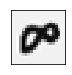

this should be [8]


In [43]:
plot_an_image(X)


In [44]:
def plot_100_image(X):
    """ 
    随机画100个数字
    """
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 随机选100个样本
    sample_images = X[sample_idx, :]  # (100,400)
    
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))

    for row in range(10):
        for column in range(10):
            ax_array[row, column].matshow(sample_images[10 * row + column].reshape((20, 20)),
                                   cmap='gray_r')
    plt.xticks([])
    plt.yticks([])        
    plt.show()

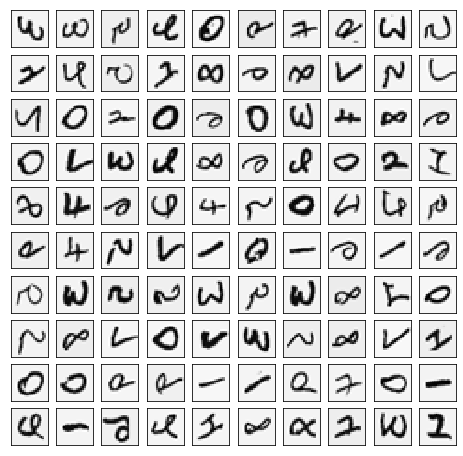

In [45]:
plot_100_image(X)

## 3、向量化逻辑回归
  我们将使用多个one-vs-all(一对多)logistic回归模型来构建一个多类分类器。由于有10个类，需要训练10个独立的分类器。为了提高训练效率，重要的是向量化。在本节中，我们将实现一个不使用任何for循环的向量化的logistic回归版本。

### （1）sigmoid 函数
g 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为： \\[g\left( z \right)=\frac{1}{1+{{e}^{-z}}}\\] 
合起来，我们得到逻辑回归模型的假设函数： 
	\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 

In [46]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### （2）向量化的代价函数。回想正则化的logistic回归的代价函数是：
$$ J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$
首先我们对每个样本$ i $要计算${{h}_{\theta }}\left( x^{(i)} \right)$,${{h}_{\theta }}\left( x^{(i)} \right)=g({\theta}^Tx^{(i)})$。
事实上我们可以对所有的样本用矩阵乘法来快速的计算。让我们如下来定义${X}$和${\theta}$
$X=\left[\begin{matrix}-(x^{(1)})^T- \cr -(x^{(2)})^T- \cr \cdots \cr -(x^{(m)})^T- \end{matrix}\right]$　　and　　
${\theta}=\left[\begin{matrix}{\theta}_0 \cr {\theta}_1 \cr \vdots \cr {\theta}_n \end{matrix}\right]$  
然后通过计算矩阵积 X${\theta}$ ，我们可以得到：$X{\theta}=\left[\begin{matrix}-(x^{(1)})^T{\theta}- \cr -(x^{(2)})^T{\theta}- \cr \cdots \cr -(x^{(m)})^T{\theta}- \end{matrix}\right]=\left[\begin{matrix}-{\theta}^T(x^{(1)})- \cr -{\theta}^T(x^{(2)})- \cr \cdots \cr -({\theta}^T(x^{(m)})- \end{matrix}\right]$  
在最后一个等式中，我们用到了一个定理，如果 a 和 b 都是向量，那么$a^Tb=b^Ta$


In [47]:
def regularized_cost(theta, X, y, l):
    """
    don't penalize theta_0
    args:
        X: feature matrix, (m, n+1) # 插入了x0=1
        y: target vector, (m, )
        l: lambda constant for regularization
    """
    thetaReg = theta[1:] #不惩罚第一项
    first = (-y*np.log(sigmoid(X@theta))) + (y-1)*np.log(1-sigmoid(X@theta))
    reg = (thetaReg@thetaReg)*l / (2*len(X))
    return np.mean(first) + reg


### 梯度下降，只需求偏导数即可
回顾正则化logistic回归代价函数的梯度下降法如下表示，因为不惩罚${\theta}_0$，所以分为两种情况：  
\begin{align}
  & Repeat\text{ }until\text{ }convergence\text{ }\!\!\{\!\!\text{ } \\ 
 & \text{     }{{\theta }_{0}}:={{\theta }_{0}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{_{0}}^{(i)}} \\ 
 & \text{     }{{\theta }_{j}}:={{\theta }_{j}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{j}^{(i)}}+\frac{\lambda }{m}{{\theta }_{j}} \\ 
 & \text{          }\!\!\}\!\!\text{ } \\ 
 & Repeat \\ 
\end{align}

In [48]:
def regularized_gradient(theta, X, y, l):
    """
    don't penalize theta_0
    args:
        l: lambda constant
    return:
        a vector of gradient
    """
    thetaReg = theta[1:]
    first = (1 / len(X)) * X.T @ (sigmoid(X @ theta) - y)
    # 这里人为插入一维0，使得对theta_0不惩罚，方便计算
    reg = np.concatenate([np.array([0]), (l / len(X)) * thetaReg])
    return first + reg

## One-vs-all Classification（一对多分类）
这部分我们将实现一对多分类通过训练多个正则化logistic回归分类器，每个对应数据集中K类中的一个。

对于这个任务，我们有10个可能的类，并且由于logistic回归只能一次在2个类之间进行分类，每个分类器在“类别 i”和“不是 i”之间决定。 我们将把分类器训练包含在一个函数中，该函数计算10个分类器中的每个分类器的最终权重，并将权重返回shape为(k, (n+1))数组，其中 n 是参数数量。


In [86]:
from scipy.optimize import minimize

def one_vs_all(X, y, l, K):
    """generalized logistic regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization
        K: numbel of labels
    return: trained parameters
    """
    all_theta = np.zeros((K, X.shape[1]))  # (10, 401)
    
    for i in range(1, K+1):
        theta = np.zeros(X.shape[1])#为theta添加了一个额外的参数（与训练数据一列），以计算截距项（常数项）
        # 获取每一个数字的y向量
        y_i = np.array([1 if label == i else 0 for label in y])
    
        ret = minimize(fun=regularized_cost, x0=theta, args=(X, y_i, l), method='TNC',
                        jac=regularized_gradient, options={'disp': True})
        all_theta[i-1,:] = ret.x
                         
    return all_theta

 这里需要注意的几点：首先，我们为X添加了一列常数项 1 ，以计算截距项（常数项）。 其次，我们将y从类标签转换为每个分类器的二进制值（要么是类i，要么不是类i）。 最后，我们使用SciPy的较新优化API来最小化每个分类器的代价函数。 如果指定的话，API将采用目标函数，初始参数集，优化方法和jacobian（渐变）函数。 然后将优化程序找到的参数分配给参数数组。

### 获得预测结果矩阵


In [87]:
def predict_all(X, all_theta):
    # 计算每个训练集样本 的 分类概率  
    h = sigmoid(X @ all_theta.T)  # 注意的这里的all_theta需要转置，因为X为(5000,401) all_theta为(10,401)，形状不匹配
    h_argmax = np.argmax(h, axis=1)
    #axis =1 每行最大值对应的index值 index:{0,1,2,3,4,5,6,7,8,9}
    #i.e 第一行(第一个训练样本)，每列（共10列）都会对第一行样本做出分类，
    #比如{0,1,0,0,0,0,0,0,0,0,} 那么这意味着该样本 属于第二类，第二列的index为1，
    #所以在index基础上加上1 就是 类别的值！ ^_^
    h_argmax = h_argmax + 1
    
    return h_argmax


这里的h共5000行，10列，每行代表一个样本，每列是预测对应数字的概率。我们取概率最大对应的index加1就是我们分类器最终预测出来的类别。返回的h_argmax是一个array，包含5000个样本对应的预测值。

In [88]:
raw_X, raw_y = load_data('ex3data1.mat')
X = np.insert(raw_X, 0, 1, axis=1) # (5000, 401)
y = raw_y.flatten()  # 这里消除了一个维度，方便后面的计算 or .reshape(-1) （5000，）

all_theta = one_vs_all(X, y, 1, 10)
all_theta  # 每一行是一个分类器的一组参数


array([[-2.38120632e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.30520871e-03, -9.34051816e-10,  0.00000000e+00],
       [-3.18336957e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.46340223e-03, -5.08880580e-04,  0.00000000e+00],
       [-4.79894740e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.86619702e-05, -2.47209891e-07,  0.00000000e+00],
       ...,
       [-7.98738710e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.94653400e-05,  7.21239651e-06,  0.00000000e+00],
       [-4.57199032e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.33791002e-03,  9.99342936e-05,  0.00000000e+00],
       [-5.40412466e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16606730e-04,  7.87540219e-06,  0.00000000e+00]])

现在准备好进行最后一步 - 使用训练完毕的分类器预测每个图像的标签。 对于这一步，我们将计算每个类的类概率，对于每个训练样本，并将输出类标签为具有最高概率的类。

In [89]:
y_pred = predict_all(X, all_theta)
accuracy = np.mean(y_pred == y)
print ('accuracy = {0}%'.format(accuracy * 100))


accuracy = 94.46%


# 神经网络 （这里只做前向传播，权值已经给出）
上面使用了多类logistic回归，然而logistic回归不能形成更复杂的假设，因为它只是一个线性分类器。

接下来我们用神经网络来尝试下，神经网络可以实现非常复杂的非线性的模型。我们将利用已经训练好了的权重进行预测。

![jupyter](https://imgconvert.csdnimg.cn/aHR0cHM6Ly91cGxvYWQtaW1hZ2VzLmppYW5zaHUuaW8vdXBsb2FkX2ltYWdlcy8xMTAyMzI2Mi04OWRjOTEyOTQ3YjNlOWVkLnBuZw)

## 加载数据集

In [90]:
def load_weight(path):#加载权重数据集
    data = loadmat(path)
    return data['Theta1'], data['Theta2']

In [91]:
theta1, theta2 = load_weight('ex3weights.mat')

theta1.shape, theta2.shape

((25, 401), (10, 26))

因为在数据加载函数中，原始数据做了转置。但是，转置的数据与给定的权重矩阵（参数）不兼容，因为这些参数是由原始数据训练的。 所以为了应用给定的参数，我需要使用原始数据（不转置）

In [99]:
X, y = load_data('ex3data1.mat')
y = y.flatten( )
X = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1)  # 为theta添加了一个额外的参数（与训练数据一列），以计算截距项（常数项）

X.shape, y.shape


((5000, 401), (5000,))

In [100]:
a1 = X
z2 = a1 @ theta1.T
z2.shape

(5000, 25)

第二层神经网络

In [101]:
z2 = np.insert(z2, 0, 1, axis=1)

In [102]:
a2 = sigmoid(z2)
a2.shape

(5000, 26)

第三层神经网络

In [103]:
z3 = a2 @ theta2.T
z3.shape

(5000, 10)

In [104]:
a3 = sigmoid(z3)
a3.shape
a3

array([[1.38245045e-04, 2.05540079e-03, 3.04012453e-03, ...,
        4.91017499e-04, 7.74325818e-03, 9.96229459e-01],
       [5.87756717e-04, 2.85026516e-03, 4.14687943e-03, ...,
        2.92311247e-03, 2.35616705e-03, 9.96196668e-01],
       [1.08683616e-04, 3.82659802e-03, 3.05855129e-02, ...,
        7.51453949e-02, 6.57039547e-03, 9.35862781e-01],
       ...,
       [6.27824726e-02, 4.50406476e-03, 3.54510925e-02, ...,
        2.63669734e-03, 6.89448164e-01, 2.74369466e-05],
       [1.01908736e-03, 7.34360211e-04, 3.78558700e-04, ...,
        1.45616578e-02, 9.75989758e-01, 2.33374461e-04],
       [5.90807037e-05, 5.41717668e-04, 2.58968308e-05, ...,
        7.00508308e-03, 7.32814653e-01, 9.16696059e-02]])

In [105]:
y_pred = np.argmax(a3, axis=1) + 1 
accuracy = np.mean(y_pred == y)
print ('accuracy = {0}%'.format(accuracy * 100))  # accuracy = 97.52%

accuracy = 97.52%
